In [1]:
import numpy as np
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit 메소드는 아무것도 학습하지 않음
    def fit(self, X, y=None):
        pass
    
    # predict 메소드는 성별만 고려하여 생존여부를 예측함
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred
    

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from handling_titanic import transform_features

titanic_df = pd.read_csv('../data/titanic/train.csv')
X = titanic_df.drop('Survived', axis=1)
y = titanic_df['Survived']

X = transform_features(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

pred_my = myclf.predict(X_test)
round(accuracy_score(y_test, pred_my), 4)

0.7877

- 성별만을 고려한 분류기가 78.77% 정확도를 보임

In [5]:
from sklearn.datasets import load_digits

# create dummy classifier
class MyFakeClassifier(BaseEstimator):

    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((X.shape[0], 1), dtype=bool)
    
digits = load_digits()

y = (digits['target'] == 7).astype(int)
X = digits['data']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

In [6]:
fake_clf = MyFakeClassifier()
fake_clf.fit(X_train, y_train)

pred_fake = fake_clf.predict(X_test)

accuracy_score(y_test, pred_fake)

0.9

- MNIST 데이터를 7인가 아닌가를 분류하는 이진문제로 만들어서 예측결과를 모두 0으로 하는 분류기가 90% 정확도를 보임

- 정확도를 평가 지표로 활용하는 것이 성능을 정확히 반영하지 못할 가능성을 고려해야 함

In [7]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, pred_fake)

array([[405,   0],
       [ 45,   0]], dtype=int64)

![Confusion Matrix](../confusion%20matrix.png)

In [10]:
from sklearn.metrics import precision_score, recall_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuray = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('Confusion Matrix')
    print(confusion)
    print('Accuracy : ', round(accuray, 4), 'Precision : ', round(precision, 4), 'Recall : ', round(recall, 4))

In [20]:
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv('../data/titanic/train.csv')
X = titanic_df.drop('Survived', axis=1)
y = titanic_df['Survived']

X = transform_features(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

lr_clf = LogisticRegression(max_iter=1000, solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

Confusion Matrix
[[108  10]
 [ 14  47]]
Accuracy :  0.8659 Precision :  0.8246 Recall :  0.7705


- 정밀도에 비해 재현율이 떨어짐

In [24]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('Shape of pred_proba : ', pred_proba.shape)
print('Sample of pred_prob : \n', pred_proba[:3])

pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('Result : \n', pred_proba_result[:3])

Shape of pred_proba :  (179, 2)
Sample of pred_prob : 
 [[0.44935228 0.55064772]
 [0.86335513 0.13664487]
 [0.86429645 0.13570355]]
Result : 
 [[0.44935228 0.55064772 1.        ]
 [0.86335513 0.13664487 0.        ]
 [0.86429645 0.13570355 0.        ]]


- threshold 설정

In [25]:
from sklearn.preprocessing import Binarizer

X = [
    [1, -1, 2],
    [2, 0, 0],
    [0, 1.1, 1.2]
    ]

binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [27]:
def set_threshold(y_test, pred_proba, threshold):
    custom_threshold = threshold
    pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

    binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
    custom_predict = binarizer.transform(pred_proba_1)
    get_clf_eval(y_test, custom_predict)

In [29]:
set_threshold(y_test, pred_proba, 0.5)

Confusion Matrix
[[108  10]
 [ 14  47]]
Accuracy :  0.8659 Precision :  0.8246 Recall :  0.7705


In [30]:
set_threshold(y_test, pred_proba, 0.4)

Confusion Matrix
[[97 21]
 [11 50]]
Accuracy :  0.8212 Precision :  0.7042 Recall :  0.8197


In [32]:
threshold_list = [0.4, 0.45, 0.50, 0.55, 0.60]

for custom_threshold in threshold_list:
    print('Custom Threshold : ', custom_threshold)
    set_threshold(y_test, pred_proba, custom_threshold)
    print('='*50)

Custom Threshold :  0.4
Confusion Matrix
[[97 21]
 [11 50]]
Accuracy :  0.8212 Precision :  0.7042 Recall :  0.8197
Custom Threshold :  0.45
Confusion Matrix
[[105  13]
 [ 13  48]]
Accuracy :  0.8547 Precision :  0.7869 Recall :  0.7869
Custom Threshold :  0.5
Confusion Matrix
[[108  10]
 [ 14  47]]
Accuracy :  0.8659 Precision :  0.8246 Recall :  0.7705
Custom Threshold :  0.55
Confusion Matrix
[[111   7]
 [ 16  45]]
Accuracy :  0.8715 Precision :  0.8654 Recall :  0.7377
Custom Threshold :  0.6
Confusion Matrix
[[113   5]
 [ 17  44]]
Accuracy :  0.8771 Precision :  0.898 Recall :  0.7213


- precision_recall_curve

In [33]:
from sklearn.metrics import precision_recall_curve

# predict probality when label = 1
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1) # 입력인자 : 실제 클래스값, positive 값의 예측 확률
print('Shape of thresholds : ', thresholds.shape)

thr_idx = np.arange(0, thresholds.shape[0], 15)
print('Value of thresholds : ', np.round(thresholds[thr_idx], 2))

print('Precision : ', np.round(precisions[thr_idx], 3))
print('Recall : ', np.round(recalls[thr_idx], 3))

Shape of thresholds :  (165,)
Value of thresholds :  [0.02 0.11 0.13 0.14 0.16 0.24 0.32 0.45 0.62 0.73 0.87]
Precision :  [0.341 0.372 0.401 0.44  0.505 0.598 0.688 0.774 0.915 0.968 0.938]
Recall :  [1.    1.    0.967 0.902 0.902 0.902 0.869 0.787 0.705 0.492 0.246]


- precision_recall_curve 시각화

In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')


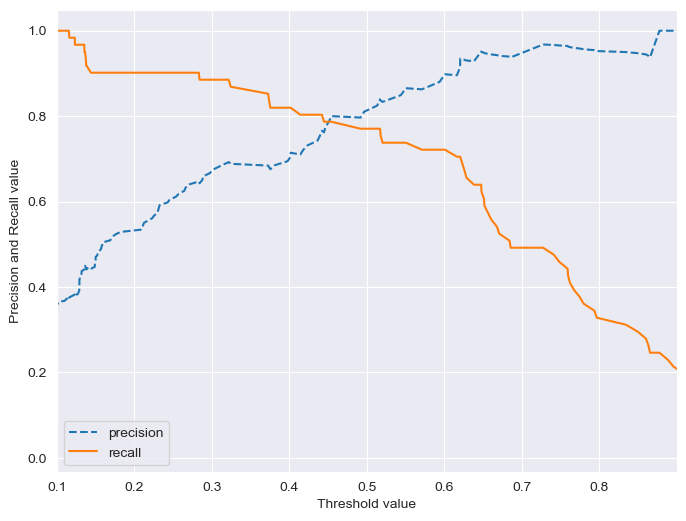

In [40]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # set threshold into X-axis and precision, recall into Y-axis
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[:threshold_boundary], ls='--', label='precision')
    plt.plot(thresholds, recalls[:threshold_boundary], ls='-', label='recall')
    
    plt.xlim((0.1, 0.9))
    plt.xticks(np.round(np.arange(0.1, 0.9, 0.1), 2))

    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

- F1_score

In [41]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred)
print('F1 Score : ', round(f1, 4))

F1 Score :  0.7966


In [42]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuray = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('Confusion Matrix')
    print(confusion)
    print('Accuracy : ', round(accuray, 4), 'Precision : ', round(precision, 4), 'Recall : ', round(recall, 4))
    print('F1 : ', round(f1, 4))


threshold_list = [0.4, 0.45, 0.50, 0.55, 0.60]

for custom_threshold in threshold_list:
    print('Custom Threshold : ', custom_threshold)
    set_threshold(y_test, pred_proba, custom_threshold)
    print('='*50)

Custom Threshold :  0.4
Confusion Matrix
[[97 21]
 [11 50]]
Accuracy :  0.8212 Precision :  0.7042 Recall :  0.8197
F1 :  0.7576
Custom Threshold :  0.45
Confusion Matrix
[[105  13]
 [ 13  48]]
Accuracy :  0.8547 Precision :  0.7869 Recall :  0.7869
F1 :  0.7869
Custom Threshold :  0.5
Confusion Matrix
[[108  10]
 [ 14  47]]
Accuracy :  0.8659 Precision :  0.8246 Recall :  0.7705
F1 :  0.7966
Custom Threshold :  0.55
Confusion Matrix
[[111   7]
 [ 16  45]]
Accuracy :  0.8715 Precision :  0.8654 Recall :  0.7377
F1 :  0.7965
Custom Threshold :  0.6
Confusion Matrix
[[113   5]
 [ 17  44]]
Accuracy :  0.8771 Precision :  0.898 Recall :  0.7213
F1 :  0.8


- roc_curve

In [43]:
from sklearn.metrics import roc_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]
fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

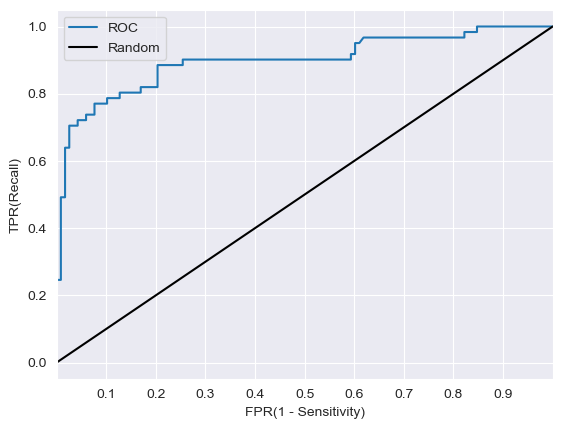

ROC SCORE :  0.8987


In [46]:
from sklearn.metrics import roc_auc_score

def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    roc_score = roc_auc_score(y_test, pred_proba_c1)
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0, 1], [0, 1], 'k-', label='Random')

    plt.xlim((0, 1))
    plt.ylabel((0, 1))
    plt.xticks(np.round(np.arange(0.1, 1.0, 0.1), 2))
    plt.xlabel('FPR(1 - Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()

    print('ROC SCORE : ', round(roc_score, 4))



roc_curve_plot(y_test, pred_proba_class1)

In [48]:
# 모델 평가를 위한 함수

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuray = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred_proba)
    print('Confusion Matrix')
    print(confusion)
    print('Accuracy : ', round(accuray, 4), 'Precision : ', round(precision, 4), 'Recall : ', round(recall, 4))
    print('F1 : ', round(f1, 4))
    print('ROC SCORE : ', round(roc_score, 4))
